In [1]:
using LinearAlgebra;
using Plots;

energy_color = "#fdce0b";
spectral_colors = cgrad(:rainbow;rev=true);

function substring(i::Int64)
    
    if (i < 0) error("Tried to subscript with a negative integer.") end
    string = ""
    for digit in digits(i)
        string = Char(0x2080+digit)*string
    end
    
    return string
end;

integral(xs,fs) = (sum(fs)-(fs[1]+fs[end])/2)*(xs[2]-xs[1]);

Setter opp et romlig 1D-gitter for systemet med bredde 20.0 og 1001 punkter.

In [2]:
ΔX = 20.0; N = 1001; δx = ΔX/(N-1);
xs = range(-ΔX/2,ΔX/2;length=N);

Spesifiserer brønnenes posisjon, dybde, bredde og potergifunksjon.

In [3]:
struct GaussianWell
    
    position::Float64
    depth::Float64
    width::Float64
    
end;

potergy(x;well) = -well.depth*exp(-((x-well.position)/2well.width)^2);

L = GaussianWell(-5.0,140.0,0.5); ΠLs = potergy.(xs;well=L);
R = GaussianWell(5.0,120.0,0.5); ΠRs = potergy.(xs;well=R);

Πs = ΠRs+ΠLs;

Finner energitilstandene i hver brønn.

In [4]:
function energy_states_n_values(well::GaussianWell , xs = xs)
    
    N = length(xs);
    δx = xs[2]-xs[1];
    
    Hamiltonian = SymTridiagonal(potergy.(xs;well=well).+1/δx^2,repeat([-1/2δx^2],N-1))
    Hamiltonian_eigen = eigen(Hamiltonian);
    χs = [Hamiltonian_eigen.vectors[:,i]/√δx for i in 1:N];
    Es = Hamiltonian_eigen.values;
    
    return (χs , Es)
end;

In [5]:
@time χLs , ELs = energy_states_n_values(L);
@time χRs , ERs = energy_states_n_values(R);

  0.578551 seconds (1.61 M allocations: 107.031 MiB, 3.30% gc time, 76.42% compilation time)
  0.088502 seconds (2.02 k allocations: 23.570 MiB)


Setter sammen en bunden energibasis med $B_L$ energitilstander fra venstre brønn og $B_R$ energitilstander fra høyre brønn. Plotter basisen.

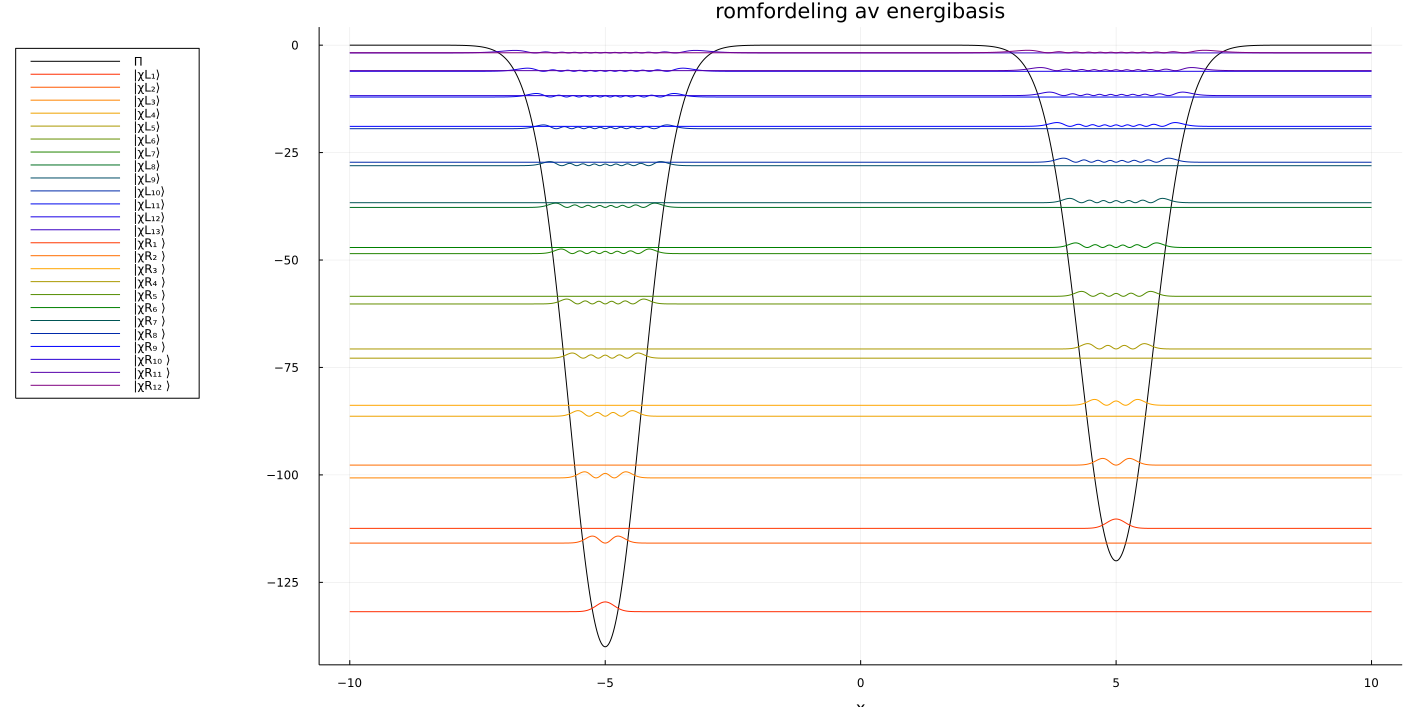

In [6]:
BL = sum(ELs .< 0.0);
BR = sum(ERs .< 0.0);
B = BL*BR;

plot(xs,Πs;title="romfordeling av energibasis",size=(1414,707),legend=:outertopleft,xlabel="x",color=:black,label="Π")
plot!(xs,[abs2.(χLs[i]).+ELs[i] for i in 1:BL];palette=palette(spectral_colors,BL+3),labels=["|χL"*substring(i)*"⟩" for _ in 1:1 , i in 1:BL])
plot!(xs,[abs2.(χRs[i]).+ERs[i] for i in 1:BR];palette=palette(spectral_colors,BR+1),labels=["|χR"*substring(i)*" ⟩" for _ in 1:1 , i in 1:BR])

Spesifiserer videre en dobbeltbrønn med Coulomb-veksling på 2500.0.

In [7]:
struct DoubleGaussianWell
    
    left_well::GaussianWell
    right_well::GaussianWell
    
    Coulomb_strength::Float64
    Coulomb_shielding::Float64
    
end

Coulomb_potergy(x1,x2;well) = well.Coulomb_strength/√((x1-x2)^2+well.Coulomb_shielding^2);

W = DoubleGaussianWell(L,R,2500.0,0.1);

Finner energibasiskoffene for hele brønnsystemet.

In [8]:
function Coulomb_R_integrals(well::DoubleGaussianWell , xs , χRs ; BR)
    
    energies = zeros(N);
    integrands = zeros(N);
    integrals = zeros(BR,BR,N);
    for n in 1:N
        energies .= Coulomb_potergy.(xs,xs[n];well=well);
        for i in 1:BR , j in i:BR
            integrands .= conj.(χRs[i]) .* energies .* χRs[j];
            integrals[i,j,n] = integral(xs, integrands);
            integrals[j,i,n] = integrals[i,j,n]';
        end
    end

    return integrals
end

function energy_coefs_n_values(well::DoubleGaussianWell , xs = xs ; BL = BL , BR = BR)
    
    N = length(xs);
    δx = xs[2]-xs[1];
    
    χLs , ELs = energy_states_n_values(well.left_well,xs);
    χRs , ERs = energy_states_n_values(well.right_well,xs);
    
    B = BR*BL;
    
    integrands = zeros(N)
    R_integrals = Coulomb_R_integrals(well,xs,χRs;BR=BR);
    Hamiltonian = zeros(B,B);
    for i in 1:BL , j in 1:BR
        I = (i-1)*BR+j;
        for  k in 1:BL , l in 1:BR
            J = (k-1)*BR+l;
            @views integrands .= conj.(χLs[i]) .* R_integrals[j,l,:] .* χLs[k];
            Hamiltonian[I,J] = (i == k)*(j == l)*(ELs[i] + ERs[j]) + integral(xs,integrands);
        end
    end
    Hamiltonian = Hermitian(Hamiltonian);
    
    Hamiltonian_eigen = eigen(Hamiltonian);
    Cs = [[Hamiltonian_eigen.vectors[(i-1)*BR+j,e] for i in 1:BL , j in 1:BR] for e in 1:B];
    Es = Hamiltonian_eigen.values;
    
    return (Cs , Es)
end;

In [9]:
@time Cs , Es = energy_coefs_n_values(W);

# 0.003844 seconds (5.04 k allocations: 817.484 KiB)
# 0.003795 seconds (5.01 k allocations: 785.984 KiB) med @views

  1.282683 seconds (2.75 M allocations: 179.359 MiB, 2.89% gc time, 67.46% compilation time)


Regner ut 2P-romfordelinga til de laveste energitilstandene som skal plottes.

In [10]:
using TensorOperations: @tensor

In [242]:
function energy_states_n_coefs_n_values(well::DoubleGaussianWell , xs = xs ; BL = BL , BR = BR , indices)
    
    N = length(xs);
    δx = xs[2]-xs[1];
    
    χLs , ELs = energy_states_n_values(well.left_well,xs);
    χRs , ERs = energy_states_n_values(well.right_well,xs);
    
    B = BR*BL;
    
    integrands = zeros(N)
    Hamiltonian = zeros(B,B);
    R_integrals = Coulomb_R_integrals(well,xs,χRs;BR=BR);
    for i in 1:BL , j in 1:BR
        I = (i-1)*BR+j;
        for  k in 1:BL , l in 1:BR
            J = (k-1)*BR+l;
            @views integrands .= conj.(χLs[i]) .* R_integrals[j,l,:] .* χLs[k];
            Hamiltonian[I,J] = (i == k)*(j == l)*(ELs[i] + ERs[j]) + integral(xs,integrands);
        end
    end
    Hamiltonian = Hermitian(Hamiltonian);
    
    Hamiltonian_eigen = eigen(Hamiltonian);
    Cs = [[Hamiltonian_eigen.vectors[(i-1)*BR+j,e] for i in 1:BL , j in 1:BR] for e in 1:B];
    Es = Hamiltonian_eigen.values;
    
    #=Xs = [zeros(N,N) for e in indices]
    for e in indices , i in 1:BL , j in 1:BR
        C = Cs[e][i,j]
        for m in 1:N
            L_product = C*χLs[i][m];
            @views Xs[e][m,:] .+= L_product.*χRs[j];
        end
    end=#
    
Xs = [zeros(N,N) for e in indices]
LRprods = zeros(N, N)
for i in 1:BL, j in 1:BR
    Li = χLs[i]
    Rj = χRs[j]
    for m in 1:N, n in 1:N
        LRprods[m, n] = Li[m] * Rj[n]
    end

    for e in indices
        Xs[e] .+= Cs[e][i, j] .* LRprods
    end
end
        
    return (Xs , Cs , Es)
end;

In [239]:
using BenchmarkTools: @btime

In [245]:
plot_indices = 1:6; plot_columns = 3; plot_rows = ceil(Int,length(plot_indices)/plot_columns);
@time Xs , Cs , Es = energy_states_n_coefs_n_values(W,xs;indices=plot_indices);

# 0.120611 seconds (2.58 M allocations: 40.491 MiB)
# 0.113624 seconds (2.58 M allocations: 40.491 MiB) etter ny løkkefølge
# (0.118427 seconds (2.58 M allocations: 40.491 MiB) med @inbounds)
# (0.121324 seconds (2.58 M allocations: 40.491 MiB) med forhåndsutpakking)
# 0.092794 seconds (1.48 M allocations: 23.847 MiB) med delprodukt i m-løkka
# 0.011414 seconds (34.19 k allocations: 5.095 MiB) med fusing av n-løkka
# 0.009054 seconds (34.19 k allocations: 2.376 MiB) med @views)
# 0.008458 seconds (34.15 k allocations: 2.346 MiB) med @views i integrands også

  1.948558 seconds (657.54 k allocations: 122.199 MiB, 0.71% gc time)


In [247]:
fasit .≈ (Xs, Cs, Es)

(true, true, true)

In [ ]:
#5.946934 seconds (8.15 M allocations: 400.370 MiB, 3.05% gc time)
#4.467070 seconds (659.42 k allocations: 7.107 GiB, 10.87% gc time)
#3.608642 seconds (659.41 k allocations: 7.100 GiB, 13.58% gc time)
#3.580823 seconds (661.29 k allocations: 7.107 GiB, 13.25% gc time)
#2.015010 seconds (657.86 k allocations: 1.277 GiB, 4.69% gc time)
#2.114911 seconds (657.54 k allocations: 122.199 MiB)
#2.003 s (657542 allocations: 122.20 MiB) Li and Ri

Regner ut Neumann-operatorene for hver energitilstand, samt 1P-romfordelinga til de laveste energitilstandene som skal plottes.

In [ ]:
@time P = [[Cs[e][i,j]*Cs[e][k,l]' for i in 1:BL , j in 1:BR , k in 1:BL , l in 1:BR] for e in 1:B];
@time ρL = [sum([P[e][:,i,:,i] for i in 1:BR]) for e in 1:B];
@time ρR = [sum([P[e][i,:,i,:] for i in 1:BL]) for e in 1:B];

@time ρs = [[sum([χLs[i][n]*ρL[e][i,j]*χLs[j][n]' for i in 1:BL , j in 1:BL])+sum([χRs[i][n]*ρR[e][i,j]*χRs[j][n]' for i in 1:BR , j in 1:BR]) for n in 1:N] for e in plot_indices];

Plotter 1P-romfordelinga til de laveste energitilstandene.

In [ ]:
plot(xs,[ρs[e].+Es[e] for e in plot_indices];
    title="1P-romfordeling av $(length(plot_indices)) energitilstander",size=(1404,707),legend=:outertopleft,palette=palette(spectral_colors,length(plot_indices)+1),
    labels=["|X"*substring(e)*"⟩" for _ in 1:1 , e in plot_indices])

Plotter 2P-romfordelinga til de laveste energitilstandene hver for seg for å få tydeligere oversikt.

In [ ]:
plot(xs[150:350],xs[650:850],[abs2.(Xs[e][150:350,650:850])' for e in plot_indices];
    plot_title="2P-romfordeling av $(length(plot_indices)) energitilstander",size=(468plot_columns,468plot_rows),layout=(plot_rows,plot_columns),seriestype=:heatmap,seriescolor=:sun,
    titles=["|X"*substring(e)*"⟩ med E = $(round(Es[e];digits=2))" for _ in 1:1 , e in plot_indices],legend=:none,xlabel="xL",ylabel="xR")

Plotter energibasiskoffene til de laveste energitilstandene.

In [ ]:
@time plot(1:BL,1:BR,[abs2.(Cs[e])' for e in plot_indices];
    plot_title="energibasiskoffer til $(length(plot_indices)) energitilstander",seriestype=:heatmap,seriescolor=:sun,size=(468plot_columns,468plot_rows),layout=(plot_rows,plot_columns),
    titles=["|X"*substring(e)*"⟩ med E = $(round(Es[e];digits=2))" for _ in 1:1 , e in plot_indices],legends=:none,xlabel="i",ylabel="j")

Finner flokningsentropien til hver energitilstand og skriver den ut for de laveste energitilstandene.

In [ ]:
function entropy(Neumannian)
    Neumannian_eigen = eigen(Neumannian);
    Ps = Neumannian_eigen.values;
    Ps = Ps[abs2.(Ps) .> 0.1^16];
    
    return -sum(Ps.*log.(Ps));
end

@time ωLs = entropy.(ρL);
@time ωRs = entropy.(ρR);
println("ωLs = $(ωLs[plot_indices])")
println("ωRs = $(ωRs[plot_indices])")

Kombinerer alt ovafor til en funksjon som finner flokningsentropien for et brønnsystem med gitte parametre, deriblant et gitt forhold mellom brønndybdene.

In [ ]:
function entropies(energy_indices ; depth_ratio = 120/140, ΔX = 20.0 , N = 1001 , BL = 5 , BR = 4, Coulomb_strength = 2500.0 , Coulomb_shielding = 0.1)
    
    xs = range(-ΔX/2,ΔX/2;length=N); δx = ΔX/(N-1);
    
    L = GaussianWell(-5.0,140.0,0.5); ΠLs = potergy.(xs;well=L);
    R = GaussianWell(5.0,depth_ratio*140.0,0.5); ΠRs = potergy.(xs;well=R);

    Πs = ΠRs+ΠLs;
    
    χLs , ELs = energy_states_n_values(L);
    χRs , ERs = energy_states_n_values(R);
    
    if (BL > sum(ELs .< 0.0) || BR > sum(ERs .< 0.0))
        println("Advarsel: Det brukes ubundne energitilstander i denne beregninga.")
    end
    
    B = BL*BR;
    
    W = DoubleGaussianWell(L,R,Coulomb_strength,Coulomb_shielding);
    
    Cs , Es = energy_coefs_n_values(W,xs;BL=BL,BR=BR);
    
    P = [[Cs[e][i,j]*Cs[e][k,l]' for i in 1:BL , j in 1:BR , k in 1:BL , l in 1:BR] for e in energy_indices];
    ρL = [sum([P[e][:,i,:,i] for i in 1:BR]) for e in energy_indices];

    return entropy.(ρL)
end;

Regner ut og plotter flokningsentropien til de laveste energitilstandene mot brønndybdeforhold for 9 ulike Coulomb-styrker med en voksende basis.

In [ ]:
plot_resolution = 11;
plot_columns = 3; plot_rows = 3;
plot_number = plot_columns*plot_rows;
ratios = range(120/140,160/140;length=plot_resolution);
# strengths = range(500,4500;length=plot_number);
strengths = [10^i for i in 0:0.5:4]
flokning = @animate for BLR in 1:min(BL,BR)
    B = BLR^2;
    if (BLR < 3)
        plot_indices = 1:B;
    else
        plot_indices = 1:9;
    end
    ωs = zeros(plot_resolution,plot_number,length(plot_indices));
    @time for i in 1:plot_resolution , j in 1:plot_number
        ωs[i,j,:] = entropies(plot_indices;depth_ratio=ratios[i],BL=BLR,BR=BLR,Coulomb_strength=strengths[j]);
    end
    plots = [plot(ratios,[ωs[:,i,e] for e in plot_indices];
        title="(Coulomb-styrke $(round(strengths[i];digits=1)))",palette=palette(spectral_colors,10),
        legend=:outertopleft,labels=["|X"*substring(e)*"⟩" for _ in 1:1 , e in plot_indices]) for i in 1:plot_number];
    plot(plots...; plot_title="flokningsentropi til $(length(plot_indices)) energitilstander med BL = BR = $BLR",size=(468plot_columns,246plot_rows),layout=(plot_rows,plot_columns))
end
gif(flokning,"dobbeltbrønn_flokning.gif";fps=1)